In [1]:
import numpy as np
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
import pandas as pd
from scipy.stats import mode
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def calculate_knn_outlier_scores(data, n_samples, sample_fraction, n_components, n_neighbors, contamination):
    """
    Performs outlier detection using PCA and KNN with voting mechanism, returning final labels and scores.
    
    Parameters:
        data (numpy.ndarray): The input dataset.
        n_samples (int): Number of random samples to generate.
        sample_fraction (float): Fraction of the data to include in each sample.
        n_components (int): Number of PCA components.
        n_neighbors (int): Number of neighbors for KNN.
        contamination (float): Contamination level for KNN.
    
    Returns:
        numpy.ndarray: A binary array indicating whether each data point is an outlier (1) or not (0).
        numpy.ndarray: Average outlier scores for each data point.
    """
    n_data_points = data.shape[0]
    sample_size = int(n_data_points * sample_fraction)
    all_labels = np.zeros((n_samples, n_data_points), dtype=int)
    all_scores = np.zeros((n_samples, n_data_points), dtype=float)
    
    for i in range(n_samples):
        # Step 1: Random sampling
        sampled_indices = np.random.choice(n_data_points, sample_size, replace=False)
        sampled_data = data[sampled_indices]
        
        # Step 2: PCA transformation
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(sampled_data)
        
        # Step 3: KNN outlier detection
        knn = KNN(n_neighbors=n_neighbors, contamination=contamination)
        knn.fit(reduced_data)
        
        # Assign outlier labels and scores to the full dataset
        full_reduced_data = pca.transform(data)
        labels = knn.predict(full_reduced_data)
        scores = knn.decision_function(full_reduced_data)  # Outlier scores
        
        all_labels[i] = labels
        all_scores[i] = scores
    
    # Step 4: Voting mechanism
    final_labels = mode(all_labels, axis=0)[0].flatten()
    average_scores = all_scores.mean(axis=0)
    
    return final_labels, average_scores

def evaluate_knn_outlier_detection(y_true, y_pred, y_scores):
    """
    Evaluates outlier detection performance using Precision, Recall, and AUC.
    
    Parameters:
        y_true (numpy.ndarray): Ground truth (0 for inliers, 1 for outliers).
        y_pred (numpy.ndarray): Predicted labels (0 for inliers, 1 for outliers).
        y_scores (numpy.ndarray): Outlier scores for each data point.
    
    Returns:
        Precision, Recall, and AUC scores.
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    return  precision, recall, auc



C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

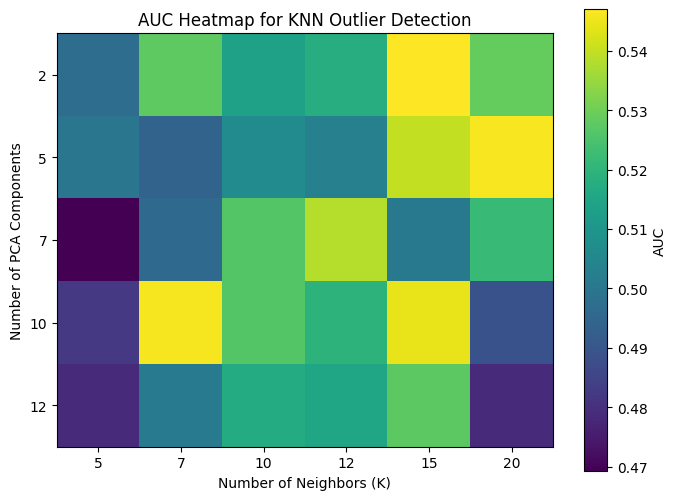

In [2]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


In [22]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.5157307709280261


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


In [23]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.7718579234972678


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

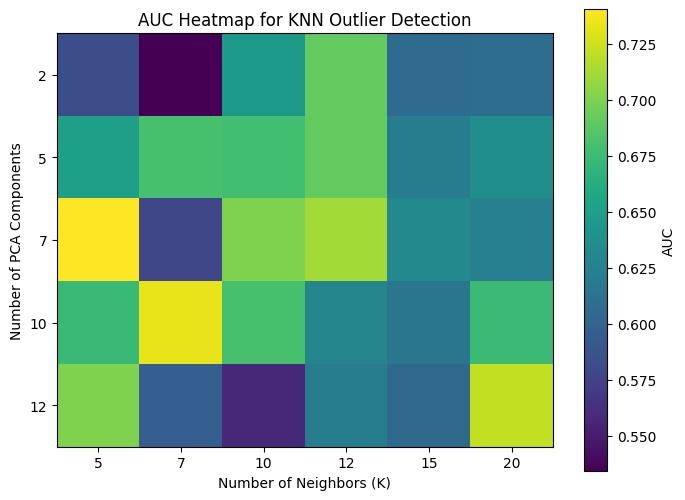

In [3]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


In [24]:
# KNN
# dataset: Cardiotocography_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Cardiotocography\\Cardiotocography_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)



Precision: 0.2926829268292683
Recall: 0.75
AUC: 0.9608383685800604


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


In [25]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.44666666666666666


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

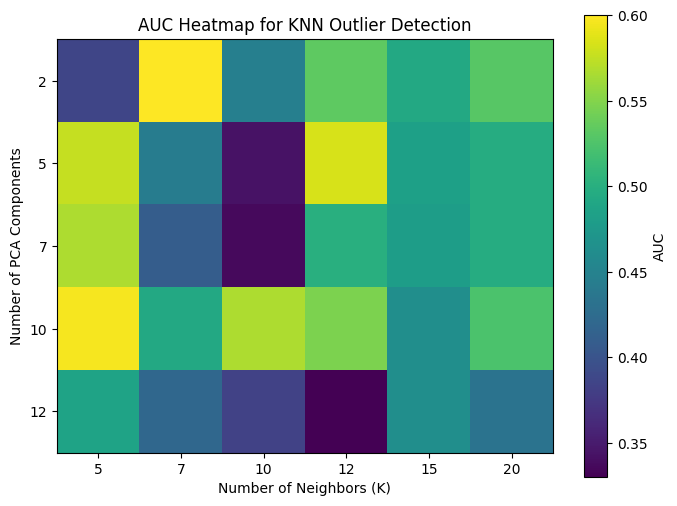

In [4]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


In [26]:
# KNN
# dataset: Hepatitis_withoutdupl_norm_05_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Hepatitis\\Hepatitis_withoutdupl_norm_05_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.6919191919191919


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

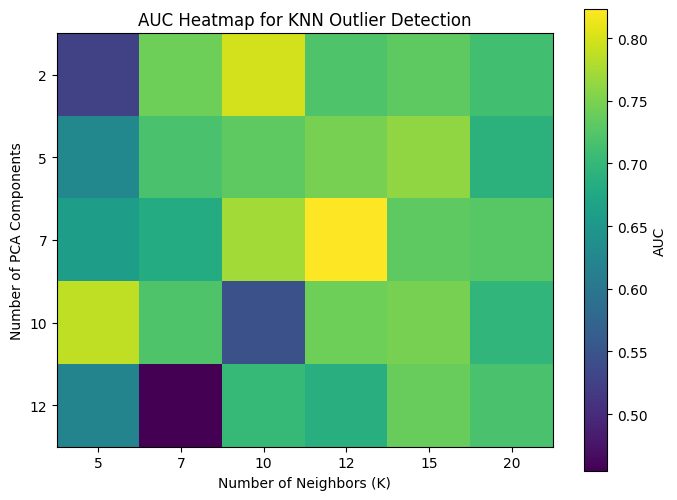

In [9]:
# KNN
# dataset: Hepatitis_withoutdupl_norm_05_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Hepatitis\\Hepatitis_withoutdupl_norm_05_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


In [27]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-2].values
    
    # Separate labels (last column)
labels = df.iloc[:, -2].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.6276595744680851


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

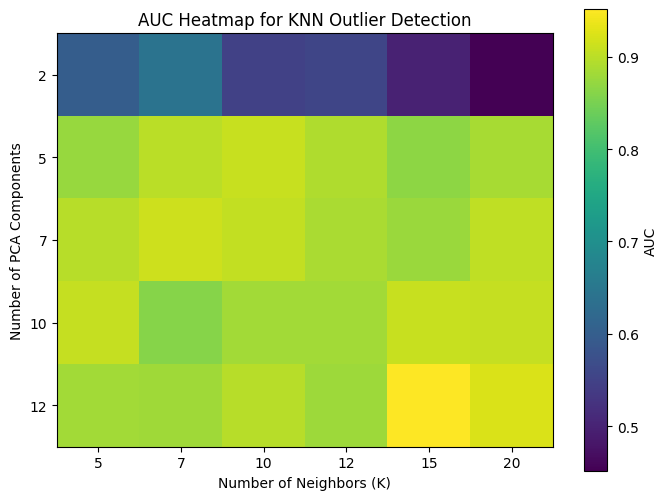

In [8]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-2].values
    
    # Separate labels (last column)
labels = df.iloc[:, -2].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


In [28]:
# KNN
# dataset: Parkinson_withoutdupl_norm_05_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Parkinson\\Parkinson_withoutdupl_norm_05_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.5
Recall: 1.0
AUC: 1.0


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


In [29]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.5662222222222222


C:\Users\asus\AppData\Local\Temp\ipykernel_9904\3321621864.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_7948\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

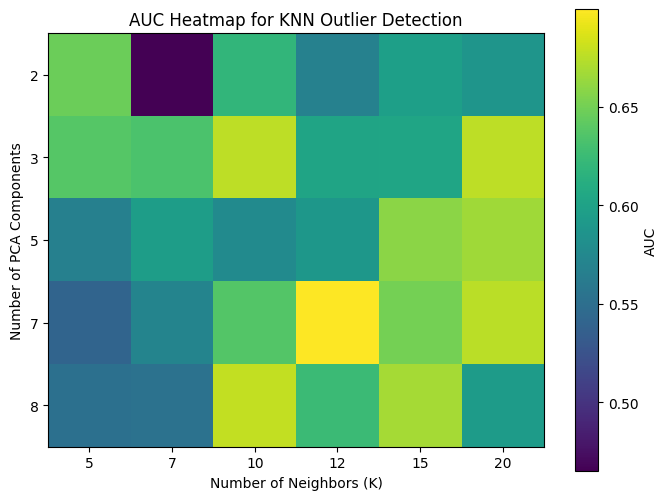

In [7]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()
